In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from PIL import Image
from sklearn.preprocessing import StandardScaler

In [2]:
images_with_mask_dir = "/kaggle/input/face-mask-dataset/data/with_mask"
images_without_mask_dir = "/kaggle/input/face-mask-dataset/data/without_mask"

In [3]:
images_with_mask = os.listdir(images_with_mask_dir)
images_without_mask = os.listdir(images_without_mask_dir)

In [4]:
print(images_with_mask[:5])
print(len(images_with_mask))
print(images_without_mask[:5])
print(len(images_without_mask))

['with_mask_3326.jpg', 'with_mask_3139.jpg', 'with_mask_696.jpg', 'with_mask_2867.jpg', 'with_mask_39.jpg']
3725
['without_mask_3248.jpg', 'without_mask_2803.jpg', 'without_mask_650.jpg', 'without_mask_2060.jpg', 'without_mask_559.jpg']
3828


# #Display few images with mask and without mask

In [5]:
def show_images(image_dir, image_files, num_images=6):
    plt.figure(figsize=(15, 7))       #size of the image we are viewing
    for i in range(num_images):   
        plt.subplot(1, num_images, i+1)       # 1 is row and num_images is cols and i+1 is index
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.axis('off')
    plt.show()


Images with masks:


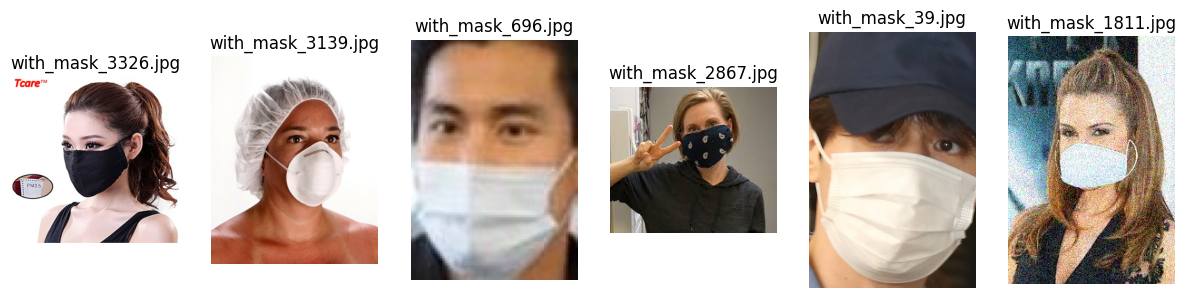

In [6]:
# Display some images with masks
print("Images with masks:")
show_images(images_with_mask_dir, images_with_mask)

Images without masks:


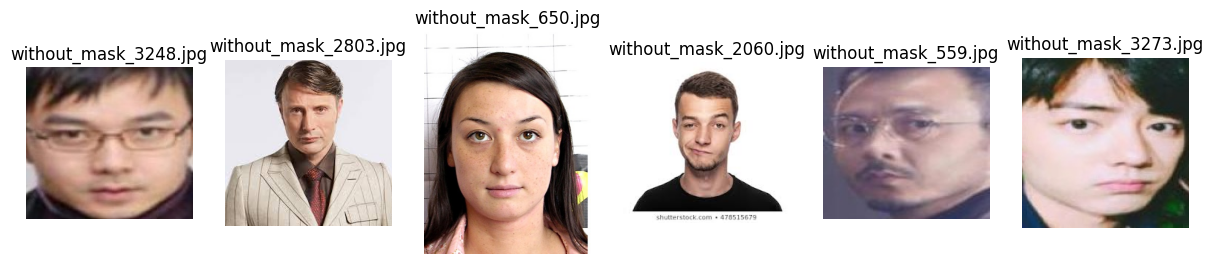

In [7]:
print("Images without masks:")
show_images(images_without_mask_dir, images_without_mask)

# Preprocessing 

In [8]:
data_path = "/kaggle/input/face-mask-dataset/data"
categories = ["with_mask","without_mask"]
data=[]
labels=[]
for category in categories:
  file_path = os.path.join(data_path,category) #with_mask and without_mask folders path
  for img in os.listdir(file_path):
    image_path = os.path.join(file_path,img)# these are images path which is present inside with_mask and without_mask folders
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert colour image to grey to reduce compputation
    resize_image = cv2.resize(gray_image,(50,50))  #resize to bring all the images to similar size
    image_array = np.array(resize_image)
    # print(image_array)
    data.append(image_array)
    if category=="with_mask":
      labels.append(1)
    elif category =="without_mask":
      labels.append(0)

In [9]:
print(data[0].shape)
print(len(data))
print(len(labels))

(50, 50)
7553
7553


In [10]:
# Check if the variable is a NumPy array
if isinstance(data[0], np.ndarray):
    print("Variable is a NumPy array")
else:
    print("Variable is not a NumPy array")

Variable is a NumPy array


In [11]:
data=np.array(data)  #shape is (7553,50,50) we have 7553 images each of size (50,50)
num_columns = data.shape[1] * data.shape[2] 
reshaped_data = data.reshape(data.shape[0], num_columns)  #(7553,2500)
df = pd.DataFrame(reshaped_data)
df['Labels'] = labels

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Labels
0,254,255,254,255,255,255,255,255,255,255,...,218,217,214,204,191,172,160,172,196,1
1,248,248,250,250,251,251,251,251,252,252,...,127,141,134,121,121,119,116,114,115,1
2,67,49,39,31,30,22,23,18,16,23,...,116,113,111,100,79,36,12,15,15,1
3,223,225,223,225,226,227,227,227,239,83,...,9,6,9,33,20,80,128,126,124,1
4,154,164,145,63,71,65,84,78,77,75,...,43,40,37,36,35,34,29,25,24,1


# Training using KNN

In [13]:
def sample_train_test_accuracy(X_train, y_train, X_test, y_test):
    subset_sizes = np.linspace(0.001, 0.3, num=10)  # 0.1% to 10%  i.e.,
# ex: - [0.001, 0.01211111,0.02322222,0.03433333,0.04544444,0.05655556,0.06766667,0.07877778,0.08988889,0.1] 
    accuracies = []
    f1_scores=[]
    for size_percentage in subset_sizes:
        # Sample subset of training data
        X_subset,_ , y_subset, _ = train_test_split(X_train, y_train, train_size=size_percentage, random_state=42)
        #I did not take test from here becuase when train is 0.1% test will be remianing 99.9% which is very high
        #To reduce the dimensionality we are using PCA
        desired_variance = 0.95
        pca = PCA(n_components=desired_variance)
        X_train_pca = pca.fit_transform(X_subset)
        X_test_pca = pca.transform(X_test)
        # kNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_pca, y_subset)
        y_pred = knn.predict(X_test_pca)
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

    plt.plot(subset_sizes * 100, accuracies, marker='o', label='Accuracy')
    plt.plot(subset_sizes * 100, f1_scores, marker='o', label='F1 Score')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Metric Score")
    plt.title("Test Metric Score vs. Training Set Size")
    plt.legend()
    plt.grid(True)
    plt.show()


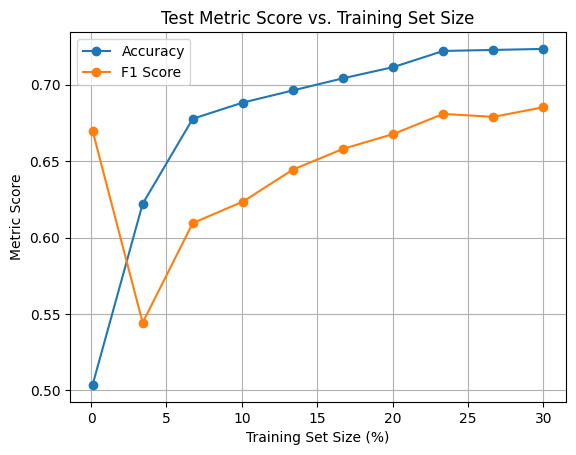

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Labels', axis=1), df['Labels'], test_size=0.2, random_state=42)
sample_train_test_accuracy(X_train, y_train, X_test, y_test)

# Training using SVM

In [15]:
def sample_train_test_accuracy_svm(X_train, y_train, X_test, y_test):
    subset_sizes = np.linspace(0.001, 0.1, num=10)  # 0.1% to 10%
    accuracies = []
    f1_scores=[]

    for size_percentage in subset_sizes:
        # Sample subset of training data
        X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=size_percentage, random_state=42)
        #To reduce the dimensionality we are using PCA
        desired_variance = 0.95
        pca = PCA(n_components=desired_variance)
        X_train_pca = pca.fit_transform(X_subset)
        X_test_pca = pca.transform(X_test)
        classifier_model = SVC(kernel='rbf')

        classifier_model.fit(X_train_pca, y_subset)
        y_pred = classifier_model.predict(X_test_pca)
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

    plt.plot(subset_sizes * 100, accuracies, marker='o', label='Accuracy')
    plt.plot(subset_sizes * 100, f1_scores, marker='o', label='F1 Score')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Metric Score")
    plt.title("Test Metric Score vs. Training Set Size")
    plt.legend()
    plt.grid(True)
    plt.show()

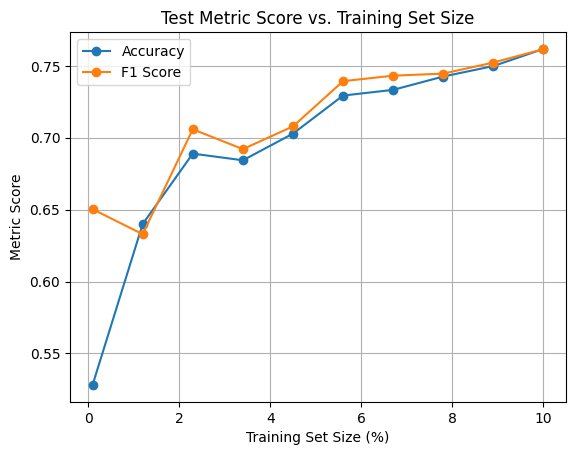

In [16]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df.drop('Labels', axis=1), df['Labels'], test_size=0.2, random_state=42)
sample_train_test_accuracy_svm(X_train1, y_train1, X_test1, y_test1)

# Training using CNN

In [17]:
categories = ["with_mask","without_mask"]
data_cnn=[]
labels_cnn=[]

path_of_data = "/kaggle/input/face-mask-dataset/data"
for category in categories:
  file_path1 = os.path.join(path_of_data,category) #with_mask and without_mask folders path
  for img in os.listdir(file_path1):
    image_path = os.path.join(file_path1,img)# these are images path which is present inside with_mask and without_mask folders
    image = cv2.imread(image_path)
    #here i am not converting the image into Grey
    resize_image = cv2.resize(image,(128,128))  #resize to bring all the images to similar size
    image_array = np.array(resize_image)
    # print(image_array)
    data_cnn.append(image_array)
    if category=="with_mask":
      labels_cnn.append(1)
    elif category =="without_mask":
      labels_cnn.append(0)

In [18]:
data_cnn[0].shape

(128, 128, 3)

In [19]:
X=np.array(data_cnn)
Y=np.array(labels_cnn)

In [20]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=2)

In [21]:
X_train_scaled=X_train/255
X_test_scaled=X_test/255

In [22]:
import tensorflow as tf
from tensorflow import keras

2024-05-01 08:40:08.773042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 08:40:08.773199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 08:40:08.936966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
num_of_classes = 2
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [25]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 376ms/step - acc: 0.6725 - loss: 0.7347 - val_acc: 0.9074 - val_loss: 0.2590
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 374ms/step - acc: 0.8688 - loss: 0.3152 - val_acc: 0.8992 - val_loss: 0.2553
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 374ms/step - acc: 0.8884 - loss: 0.2624 - val_acc: 0.9140 - val_loss: 0.1946
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - acc: 0.9143 - loss: 0.2232 - val_acc: 0.9306 - val_loss: 0.1887
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 374ms/step - acc: 0.9360 - loss: 0.1742 - val_acc: 0.8975 - val_loss: 0.2587


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,202,120 (84.69 MB)

 Trainable params: 7,400,706 (28.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,801,414 (56.46 MB)

In [27]:
loss,accuracy=model.evaluate(X_test_scaled,Y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - acc: 0.8906 - loss: 0.3021


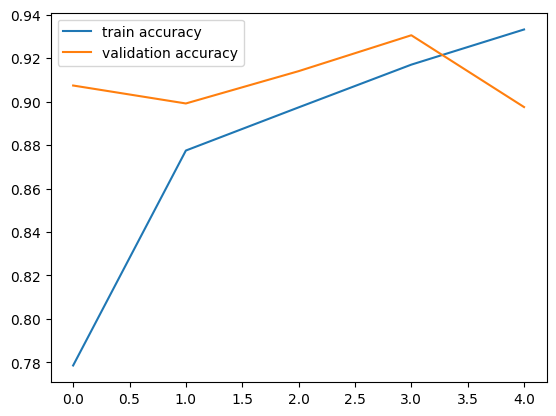

In [28]:
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')

plt.legend()
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Prediction on test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = ['without_mask', 'with_mask']
print(classification_report(Y_test, y_pred, target_names=class_names))

# Model Evaluation
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step
              precision    recall  f1-score   support

without_mask       0.85      0.96      0.90       768
   with_mask       0.95      0.82      0.88       743

    accuracy                           0.89      1511
   macro avg       0.90      0.89      0.89      1511
weighted avg       0.90      0.89      0.89      1511

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - acc: 0.8906 - loss: 0.3021
Test Loss: 0.2981202304363251
Test Accuracy: 0.8914626240730286


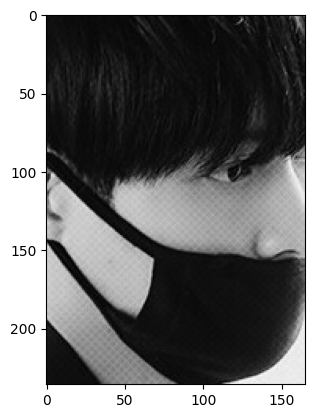

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.01641918 0.8753458 ]]
1
The person in the image is wearing a mask


In [30]:
input_image_path = '/kaggle/input/face-mask-dataset/data/with_mask/with_mask_1003.jpg'

input_image = cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

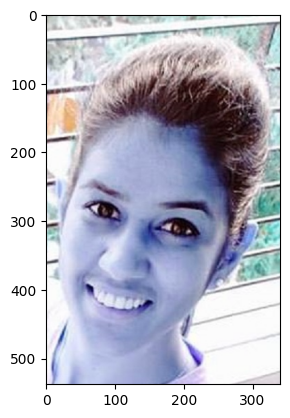

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.7112591  0.04249671]]
0
The person in the image is not wearing a mask


In [31]:
input_image_path = '/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1006.jpg'

input_image = cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')